In [1]:
import glob, re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
import utils
key = 'SK_ID_CURR'
target = 'TARGET'
app = utils.read_df_pkl('../input/clean_cpy_app*').reset_index()

100%|██████████| 3/3 [00:00<00:00, 10.93it/s]


In [2]:
# 描画の目的ごとにデータセットを分ける
train = app[~app[target].isnull()]
test = app[app[target].isnull()]
app0 = train[train[target]==0]
app1 = train[train[target]==1]

current applicatoinにSK_ID_BUREAUをmergeし、SK_ID_BUREAUが時系列と相関していると仮定. 
SK_ID_BUREAUを30ビンにして各ビンの金利feature平均をプロットすることで、各時系列点（仮）の金利がどのようになっているか見る.

100%|██████████| 3/3 [00:00<00:00, 14.61it/s]


<Figure size 864x576 with 0 Axes>

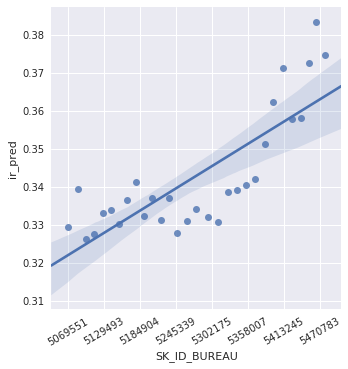

<Figure size 864x576 with 0 Axes>

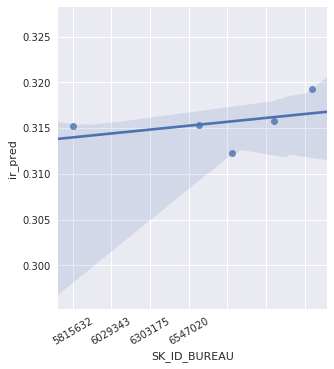

In [18]:
kb = 'SK_ID_BUREAU'
bins = 30
train_ir = utils.read_pkl_gzip('../features/4_winner/train_ir_pred@.gz')
test_ir = utils.read_pkl_gzip('../features/4_winner/test_ir_pred@.gz')
ir = np.hstack((train_ir, test_ir))
app['ir_pred'] = ir

bur = utils.read_df_pkl('../input/clean_bur*')
ab_ir = app.merge(bur, on=key, how='inner')

tmp = ab_ir.groupby(key)[['SK_ID_BUREAU', target, 'ir_pred']].max().reset_index()
train = tmp[tmp[target]>=0]
test = tmp[tmp[target].isnull()]

plt.figure(figsize=(12,8))

train[kb] = pd.qcut(q=bins, x=train[kb])
train = train.groupby(kb)['ir_pred'].mean().reset_index()
train[kb] = train[kb].map(lambda x: int(str(x)[1:8]))
lm_train = sns.lmplot(x=kb, y='ir_pred', data=train)
lm_train.set_xticklabels(rotation=30, labels=train[kb])
plt.show()

plt.figure(figsize=(12,8))
test[kb] = pd.qcut(q=5, x=test[kb])
test = test.groupby(kb)['ir_pred'].mean().reset_index()
test[kb] = test[kb].map(lambda x: int(str(x)[1:8]))
lm_test = sns.lmplot(x=kb, y='ir_pred', data=test)
lm_test.set_xticklabels(rotation=30, labels=test[kb])
plt.show()

#### 金利featureの可視化を行う
1. TARGET==1
2. TARGET==0
3. TEST
それぞれで描画する

100%|██████████| 3/3 [00:00<00:00, 14.59it/s]


*** CNT_PAYMENT@ ***


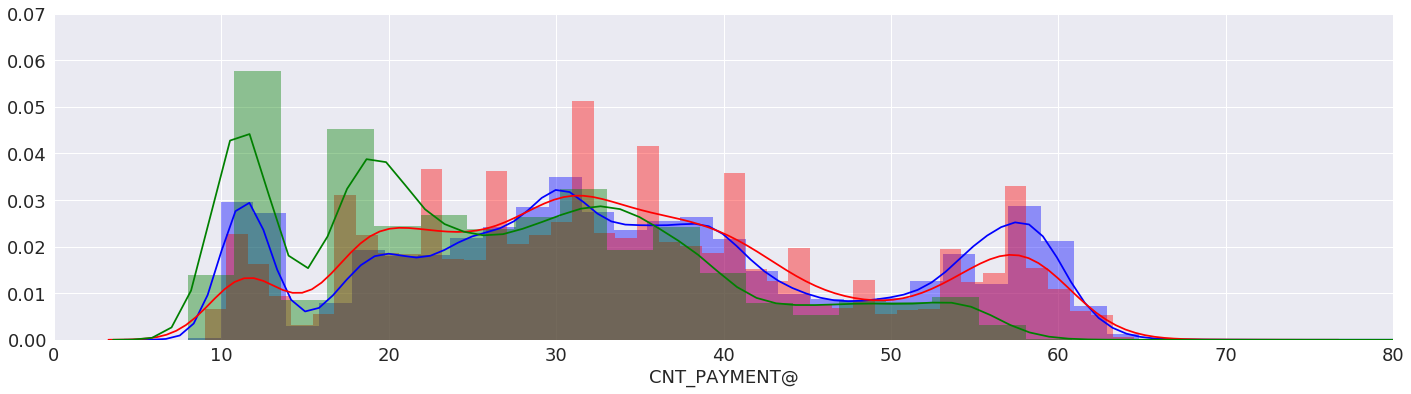

*** ir_pred@ ***


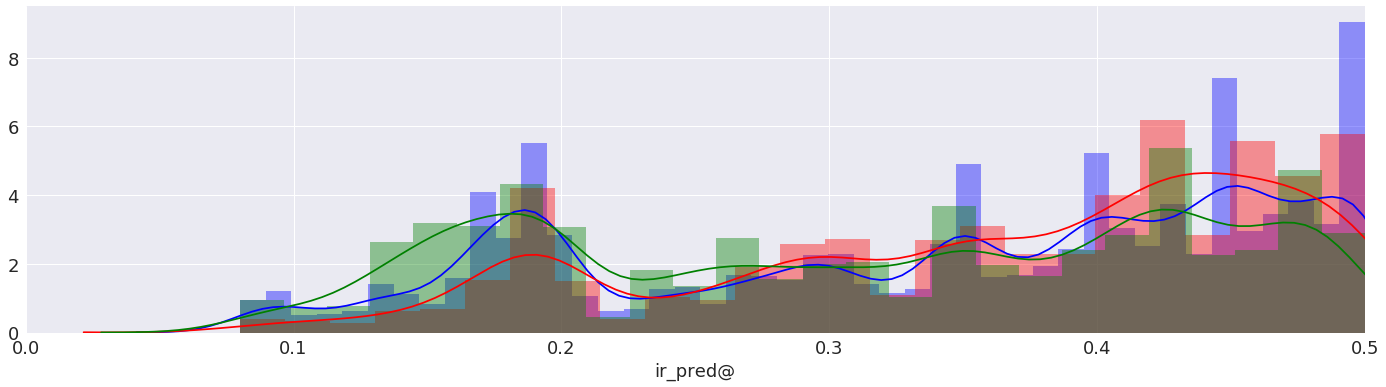

In [42]:
app = utils.read_df_pkl('../input/clean_cpy_app*').reset_index()[[key, target]]

feat_list = glob.glob('../features/4_winner/*.gz')
train_ir_list = sorted([col for col in feat_list if (col.count('ir_') or col.count('CNT_PAY')) and col.count('train')])
test_ir_list = sorted([col for col in feat_list if (col.count('ir_') or col.count('CNT_PAY')) and col.count('test')])

# train_ir_list = sorted([col for col in feat_list if col.count('rate') and col.count('train')])
# test_ir_list = sorted([col for col in feat_list if col.count('rate') and col.count('test')])
# ir_list = [col for col in app.columns if col.count('rate')]

for train_path, test_path in zip(train_ir_list, test_ir_list):
    train_ir = utils.read_pkl_gzip(train_path)
    test_ir = utils.read_pkl_gzip(test_path)
    ir = np.hstack((train_ir, test_ir))
    filename = re.search(r'/([^/.]*).gz', train_path).group(1)
    app[filename[6:]] = ir

ir_list = [col for col in app.columns if col.count('ir_') or col.count('CNT_PAY')]
train = app[app[target]>=0]
test = app[app[target].isnull()]
tmp0 = train[train[target]==0]
tmp1 = train[train[target]==1]

for ir in ir_list:
    t0 = tmp0[ir].dropna()
    t1 = tmp1[ir].dropna()
    viz_train = train[ir].dropna()
    viz_test = test[ir].dropna()
    
    #========================================================================
    # TARGET 1 vs 0 vs Test
    #========================================================================
    
    print(f'*** {ir} ***')
    plt.figure(figsize=(24,6))
    sns.distplot(a=t0, color='b')
    sns.distplot(a=t1, color='r')
    fig = sns.distplot(a=viz_test, color='g')
    if ir.count('CNT_PAY'):
        max_val = 80
        fig.set(ylim=(0, 0.07))
    else:
        max_val = app[ir].max()
    fig.set(xlim=(0, max_val))
    plt.xlabel(ir, fontsize=18)
    plt.tick_params(labelsize=18)
    
    plt.show()
#     #========================================================================
#     # Train vs Test
#     #========================================================================
#     plt.figure(figsize=(24,6))
#     sns.distplot(a=viz_train, color='b')
#     sns.distplot(a=viz_test, color='g')
#     plt.show()

In [ ]:
app = utils.read_df_pkl('../input/clean_cpy_app*').reset_index()[[key, target]]

feat_list = glob.glob('../features/4_winner/*.gz')
train_ir_list = sorted([col for col in feat_list if col.count('ir_') and col.count('train')])
test_ir_list = sorted([col for col in feat_list if col.count('ir_') and col.count('test')])

for train_path, test_path in zip(train_ir_list, test_ir_list):
    train_ir = utils.read_pkl_gzip(train_path)
    test_ir = utils.read_pkl_gzip(test_path)
    ir = np.hstack((train_ir, test_ir))
    filename = re.search(r'/([^/.]*).gz', train_path).group(1)
    app[filename[6:]] = ir

bur = utils.read_df_pkl('../input/clean_bur*')
ab_ir = app.merge(bur, on=key, how='inner')

ir_list = [col for col in ab_ir.columns if col.count('ir_')]
tmp = ab_ir.groupby(key)[['SK_ID_BUREAU', target]+ir_list].max().reset_index()
train = tmp[tmp[target]>=0]
test = tmp[tmp[target].isnull()]

kb = 'SK_ID_BUREAU'
bins = 30
train[kb] = pd.qcut(q=bins, x=train[kb])
test[kb] = pd.qcut(q=bins, x=test[kb])
tmp0 = train[train[target]==0]
tmp1 = train[train[target]==1]

bureau = False
bureau = True
for ir in ir_list:
    if bureau:
#         t0 = tmp0.groupby(kb)[ir].mean().reset_index()
#         t1 = tmp1.groupby(kb)[ir].mean().reset_index()
#         t0[kb] = t0[kb].map(lambda x: int(str(x)[1:8]))
#         t1[kb] = t1[kb].map(lambda x: int(str(x)[1:8]))
        
        # irのみ描画する時
#         viz_train = train.groupby(kb)[ir].mean()
#         viz_test = test.groupby(kb)[ir].mean()
        viz_train = train[ir].dropna()
        viz_test = test[ir].dropna()

        # SK_ID_BUREAUも一緒に描画するとき
#         viz_train = train.groupby(kb)[ir].mean().reset_index()
#         viz_train[kb] = viz_train[kb].map(lambda x: int(str(x)[1:8]))
#         viz_test = test.groupby(kb)[ir].mean().reset_index()
#         viz_test[kb] = viz_test[kb].map(lambda x: int(str(x)[1:8]))
    else:
        t0 = tmp0[ir].dropna()
        t1 = tmp1[ir].dropna()
        viz_train = train[ir].dropna()
        viz_test = test[ir].dropna()
    
    #========================================================================
    # Train vs Test
    #========================================================================
    print(f'*** {ir} ***')
    plt.figure(figsize=(24,6))
    # lm_viz_test = sns.lmplot(x=kb, y=ir, data=viz_test)
    # lm_viz_test.set_xticklabels(rotation=60, labels=viz_test[kb])
#     sns.distplot(a=viz_train[ir], bins=12, color='b')
#     sns.distplot(a=viz_test[ir], bins=12, color='g')
#     plt.show()
    
    #========================================================================
    # TARGET 1 vs 0
    #========================================================================
    # lm_viz_train = sns.lmplot(x=kb, y=ir, data=viz_train)
    # lm_viz_train.set_xticklabels(rotation=60, labels=viz_train[kb])
    # lm_viz_train = sns.distplot(a=viz_train[ir], bins=12)
    plt.figure(figsize=(24,6))
    sns.distplot(a=viz_train, color='b')
#     sns.distplot(a=t0, color='b')
#     sns.distplot(a=t1, color='r')
    sns.distplot(a=viz_test, color='g')
    plt.show()